# Exporting NBA Data to a SQL file

This project can be found on GitHub: 
https://github.com/LiamWhitenack/CDS302FinalProject

NBA data (in the correct format) can be downloaded at this link:
https://www.advancedsportsanalytics.com/nba-raw-data

In [1]:
import pandas as pd # for data wrangling and storage
import numpy as np # for data wrangling
import sqlite3 as sql # for connecting to a SQL server
import os # for deleting a file if it has already been made
import seaborn as sns # for visualizations
import matplotlib.pyplot as plt

if os.path.exists('nba.db'):  # If you wish to make a new file, automatically delete the old one
    os.remove("nba.db")

nba = pd.read_csv('https://raw.githubusercontent.com/LiamWhitenack/CDS302FinalProject/main/Final_Project_NBA_data.csv')
# download the data from github

def df_to_list(df):
    rows = []
    for index, row in df.iterrows():
        rows.append(row)
    return rows
# this function will turn a pd dataframe into a simple list

In [20]:
cnn = sql.connect('nba.db')
cursor = cnn.cursor()
# create a SQL connection

### Create entity tables in SQL

This following code block will create three different datasets: player, game, and team. These three datasets are all subsets of the entire .csv file

In [2]:
cursor.execute('''CREATE TABLE IF NOT EXISTS Game
              (game_id CHAR(12) PRIMARY KEY, 
              game_date DATE,
              winner CHAR(3),
              score VARCHAR(10),
              OT INT(10), 
              home CHAR(3), 
              away CHAR(3),
              season INT(2050)
              )''')

cursor.execute('''CREATE TABLE IF NOT EXISTS Team
              (Team_Abbrev CHAR(5) NOT NULL,
              game_id CHAR(12) NOT NULL,
              win BINARY,
              Team_Score INT(200), 
              Team_pace FLOAT(0), 
              Team_efg_pct FLOAT(0), 
              Team_tov_pct FLOAT(0), 
              Team_orb_pct FLOAT(0), 
              Team_ft_rate FLOAT(0), 
              Team_off_rtg FLOAT(0), 
              Inactives FLOAT(0), 
              Opponent_Abbrev CHAR(3), 
              Opponent_Score INT(200), 
              Opponent_pace FLOAT(0), 
              Opponent_efg_pct FLOAT(0), 
              Opponent_tov_pct FLOAT(0), 
              Opponent_orb_pct FLOAT(0), 
              Opponent_ft_rate FLOAT(0), 
              Opponent_off_rtg FLOAT(0),
              season INT(2050),
              CONSTRAINT primary_key_name PRIMARY KEY (Team_Abbrev, game_id)
              )''')

cursor.execute('''CREATE TABLE IF NOT EXISTS Player
              (player_name VARCHAR(255),
              player_id CHAR(9) NOT NULL,
              game_id CHAR(12) NOT NULL,
              starter BINARY, 
              mp INT(60), 
              fg INT(100), 
              fga INT(100), 
              fg_pct FLOAT(0), 
              fg3 INT(60), 
              fg3a INT(60), 
              fg3_pct FLOAT(0), 
              ft INT(60), 
              fta INT(60), 
              ft_pct FLOAT(0), 
              orb INT(60), 
              drb INT(60), 
              trb INT(60), 
              ast INT(60), 
              stl INT(60), 
              blk INT(60), 
              tov INT(60), 
              pf INT(60), 
              pts INT(200), 
              plus_minus INT(60), 
              did_not_play BINARY, 
              is_inactive BINARY, 
              ts_pct FLOAT(0), 
              efg_pct FLOAT(0), 
              fg3a_per_fga_pct FLOAT(0), 
              fta_per_fga_pct FLOAT(0), 
              orb_pct FLOAT(0), 
              drb_pct FLOAT(0), 
              trb_pct FLOAT(0), 
              ast_pct FLOAT(0), 
              stl_pct FLOAT(0), 
              blk_pct FLOAT(0), 
              tov_pct FLOAT(0), 
              usg_pct FLOAT(0), 
              off_rtg FLOAT(0), 
              def_rtg FLOAT(0), 
              bpm FLOAT(0), 
              minutes  FLOAT(0), 
              double_double BINARY, 
              triple_double BINARY, 
              DKP  FLOAT(0), 
              FDP FLOAT(0), 
              SDP FLOAT(0), 
              DKP_per_minute FLOAT(0), 
              FDP_per_minute FLOAT(0), 
              SDP_per_minute FLOAT(0), 
              pf_per_minute FLOAT(0), 
              ts FLOAT(0), 
              last_60_minutes_per_game_starting FLOAT(0), 
              last_60_minutes_per_game_bench FLOAT(0), 
              PG_pct FLOAT(0), 
              SG_pct FLOAT(0), 
              SF_pct FLOAT(0), 
              PF_pct FLOAT(0), 
              C_pct FLOAT(0), 
              active_position_minutes FLOAT(0),
              season INT(2050),
              CONSTRAINT primary_key_name PRIMARY KEY (player_id, game_id)
              )''')


## Create Relationship Table in SQL

Making relationship tables is much easier since two of the entities are weak entities anyway. Only one relationship set must be made: the relationship that connects players to teams.

In [3]:

cursor.execute('''CREATE TABLE IF NOT EXISTS plays_for
              (player_id CHAR(12) NOT NULL,
              Team_Abbrev CHAR(9) NOT NULL,
              season INT(2050),
              CONSTRAINT primary_key_name PRIMARY KEY (Team_Abbrev, player_id)
              )''')

### Wrangle Game Data

The individual game data was the trickiest to minimize into necessary information and certain columns were added

In [4]:
# Select important columns
game = nba[['game_id', 'game_date', 'OT', 'H_A', 'Team_Abbrev', 'Team_Score', 'Opponent_Abbrev', 'Opponent_Score', 'season']]

# get rid of all away games
game = game.drop(game[game.H_A == 'A'].index)

# calculate the winner of each game
game['winner'] = np.where(game.Opponent_Score < game.Team_Score, game.Opponent_Abbrev, game.Team_Abbrev)

# remove all duplicate games
game = game.drop_duplicates(subset = ['game_id'])

# sort by the game date
game = game.sort_values(by = 'game_date')

# Create a new column, the final score
game["score"] = game["Team_Score"].astype(str) + '-' + game["Opponent_Score"].astype(str)

# select the necessary columns and organize them
game = game[['game_id', 'game_date', 'winner', 'score', 'OT', 'Team_Abbrev', 'Opponent_Abbrev', 'season']]

### Wrangle Team Data

The team data in this code chunk is not calculated for an individual team, but for a team at a certain game. For this reason, both the team name and the game id are both considered primary keys.

In [5]:
team = nba

team['win'] = np.where(team.Opponent_Score < team.Team_Score, 1, 0)

team = team[['Team_Abbrev','game_id','win','Team_Score','Team_pace','Team_efg_pct','Team_tov_pct','Team_orb_pct','Team_ft_rate','Team_off_rtg','Inactives','Opponent_Abbrev','Opponent_Score','Opponent_pace','Opponent_efg_pct','Opponent_tov_pct','Opponent_orb_pct','Opponent_ft_rate','Opponent_off_rtg','season']]

team = team.drop_duplicates(subset = ['game_id', 'Team_Abbrev'])

team = team.sort_values(by = 'Team_Abbrev')

### Wrangle Player Data

Rinse and Repeat

In [6]:
player = nba[['player','player_id','game_id','starter','mp','fg','fga','fg_pct','fg3','fg3a','fg3_pct','ft','fta','ft_pct','orb','drb','trb','ast','stl','blk','tov','pf','pts','plus_minus','did_not_play','is_inactive','ts_pct','efg_pct','fg3a_per_fga_pct','fta_per_fga_pct','orb_pct','drb_pct','trb_pct','ast_pct','stl_pct','blk_pct','tov_pct','usg_pct','off_rtg','def_rtg','bpm','minutes','double_double','triple_double','DKP','FDP','SDP','DKP_per_minute','FDP_per_minute','SDP_per_minute','pf_per_minute','ts','last_60_minutes_per_game_starting','last_60_minutes_per_game_bench','PG%','SG%','SF%','PF%','C%','active_position_minutes','season',]]

player = player.drop_duplicates(subset = ['game_id', 'player_id'])

player = player.sort_values(by = 'player')

## Relationsip Table Wrangling

In [7]:
played_for = nba[['player_id', 'Team_Abbrev', 'season']].drop_duplicates(subset = ['Team_Abbrev', 'player_id'])

## Upload all data to SQL

In [8]:
# Upload the pandas df's to SQL.

cursor.executemany('insert into Game values (?,?,?,?,?,?,?,?)', df_to_list(game))
cursor.executemany('insert into Team values (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)', df_to_list(team))
cursor.executemany('insert into Player values (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)', df_to_list(player))
cursor.executemany('insert into plays_for values (?,?,?)', df_to_list(played_for))

# Commit the changes to SQL

cnn.commit()

## Does free throw rate affect field goal percentage?

Let's use this new ability to use SQL to make some new observations that we couldn't earlier. It seems like intuition to say that if someone is better at drawing fouls and shooting free throws, then he would usually be better at making shots. Let's see if this is true

In [9]:
cursor.execute('''
SELECT player_name, AVG(fg_pct) fg_pct, AVG(fta) fta_pg, COUNT(*) num_games
FROM player
GROUP BY player_id
HAVING num_games > 41
ORDER BY fta_pg DESC ''')
obs = pd.DataFrame(cursor.fetchall(), columns = ['name', 'fg%', 'fta_pg', 'games'])

In [10]:
obs['avl'] = obs['games']/82

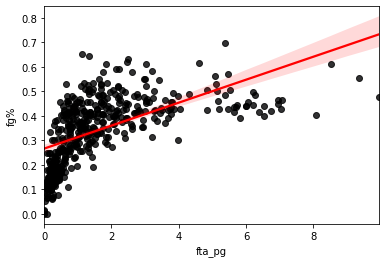

In [11]:
sns.scatterplot(data=obs, x="fta_pg", y="fg%", alpha = 0.03)
sns.regplot(data=obs, x="fta_pg", y="fg%", color = "red", scatter_kws={"color": "black"})
plt.show()

## Do teams that shoot more 3-pointers win more games?

Recently in the NBA, a sort of 3-pointer revolution has occured, where the teams with great long distance shooting are also the teams that perform the best. Let's see if this held true for the 2021 season:

In [12]:
cursor.execute('''
SELECT avg(pct_3pa) pct_3pa, AVG(fg3_pct) fg3_pct, Team_Abbrev, AVG(win) as won
FROM team NATURAL JOIN (
select avg(fg3a_per_fga_pct) pct_3pa, AVG(fg3_pct) fg3_pct, COUNT(*) num_games, Team_Abbrev
FROM player NATURAL JOIN plays_for
GROUP BY player_id
)
GROUP BY Team_Abbrev ''')
obs = pd.DataFrame(cursor.fetchall(), columns = ['3pt_fg%', 'pct_fg_3pt', 'Team', 'win%'])

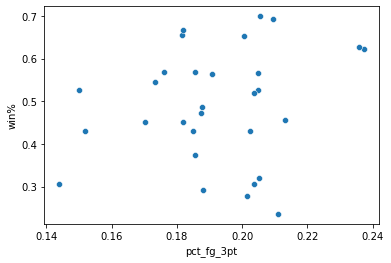

In [13]:
# Plot the number of 3 pointers shot vs. the win%

sns.scatterplot(data = obs, x = 'pct_fg_3pt', y = 'win%')
plt.show()

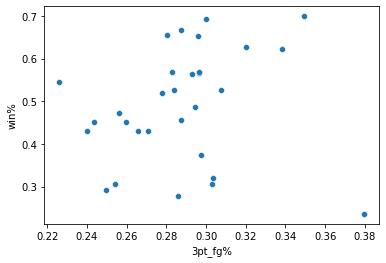

In [14]:
# Plot the 3point%  vs. the win%
sns.scatterplot(data = obs, x = '3pt_fg%', y = 'win%')
plt.show()

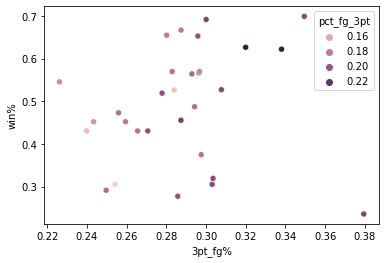

In [15]:
#combine
sns.scatterplot(data = obs, x = '3pt_fg%', y = 'win%', hue = 'pct_fg_3pt')
plt.show()

## Does free throw percentage correspond to a high 3 point percentage?

This has been a commonly stated observation for a while: a high free throw percentage is usually a sign of a talented shooter. Let's see if this has any merit

In [29]:
cursor.execute('''
SELECT player_name, avg(fg3_pct), avg(ft_pct)
FROM Player
GROUP BY player_id
HAVING COUNT(*) > 20 AND avg(ft_pct) > 0.5 AND sum(fg3a) > 200 ''')
obs = pd.DataFrame(cursor.fetchall(), columns = ['name', '3pt', 'ft'])

<AxesSubplot:xlabel='ft', ylabel='3pt'>

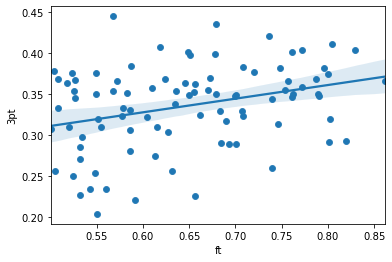

In [31]:
sns.scatterplot(data = obs, x = 'ft', y = '3pt')
sns.regplot(data = obs, x = 'ft', y = '3pt')

In [18]:
# Close the cursor and the connection

cursor.close()
cnn.close()